# Определение возраста покупателей

## В данной работе мы обучим модель нейронной сети которая сможет определять возраст покупателей магазина,что поможет бизнесу:
#### 1 Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
#### 2 Контролировать добросовестность кассиров при продаже алкоголя

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D ,MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [48]:
labels = pd.read_csv('labels.csv')
new_labels = labels.drop('Unnamed: 0',axis=1)
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=new_labels,
    directory='image',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


In [49]:
new_labels.shape

(7591, 2)

Выборка относительно небольшая,но мы еще можем нарастить ее, применяя аугментации.Для обучение воспользуемся GPU.

In [50]:
labels.isna().sum()

Unnamed: 0    0
file_name     0
real_age      0
dtype: int64

Text(0.5, 1.0, 'Age')

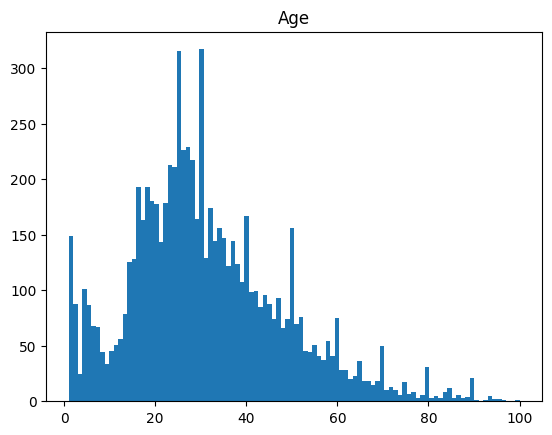

In [51]:
plt.hist(new_labels['real_age'], bins=100)
plt.title('Age')

Большая часть людей на изображениях в возрасте от 18-30.
Если обратить внимание на пике в районе 'юбилейных',можно сделать предположение что часть этих данных не была известна точно и тот кто размечал данные,округлял возраст.

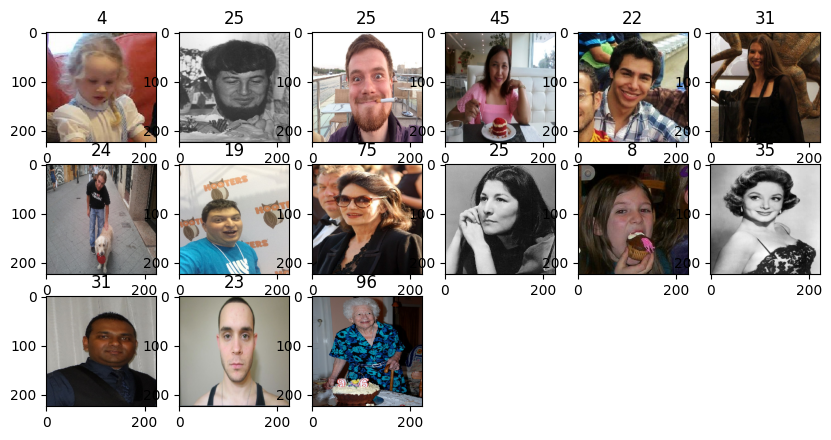

In [52]:
features, target = next(train_datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(6, 6, i+1)
    plt.imshow(features[i])
    plt.title(target[i])

Некоторые изображения обрезаны,часть изображений одноканальны(черно-белые),так же помехой для обучения модели будут фото не по центру и на которых не полностью видно лицо(очки,головные уборы,пузыри с жвачек)

## Обучение модели

```python
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.20,
        horizontal_flip=True,
        width_shift_range=0.2,
        rescale=1 / 255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
       validation_split=0.20,
       rescale=1 / 255.)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)

    model.add(Conv2D(filters=16, kernel_size=(5, 5), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(Conv2D(filters=10, kernel_size=(5, 5), input_shape=input_shape, activation='relu', padding='same'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.00001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
      steps_per_epoch = len(train_data)
    if validation_steps is None:
      validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=(test_data),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```


Train for 380 steps, validate for 95 steps

Epoch 1/5
2022-10-20 00:40:29.922606: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-20 00:40:31.976866: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
380/380 - 115s - loss: 628.4809 - mae: 18.8881 - val_loss: 672.4903 - val_mae: 20.7053

Epoch 2/5
380/380 - 91s - loss: 105.0571 - mae: 7.9065 - val_loss: 156.1245 - val_mae: 9.5478

Epoch 3/5
380/380 - 92s - loss: 76.7027 - mae: 6.7681 - val_loss: 92.8498 - val_mae: 7.2696

Epoch 4/5
380/380 - 91s - loss: 59.5315 - mae: 5.9792 - val_loss: 85.0757 - val_mae: 6.8868

Epoch 5/5
380/380 - 92s - loss: 47.1048 - mae: 5.3556 - val_loss: 84.3988 - val_mae: 6.8772
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 8s - loss: 84.3988 - mae: 6.8772
Test MAE: 6.8772

## Анализ обученной модели

Для определения возраста клиентов мы использовали модель ResNet50 с светрточными слоями и регрессионной функцией активации, оценивали ее работу метрикой средней абсолютной ошибки.

С каждой эпохой модель возвращала результаты и всё меньше переобучалась.

Нам удалось получить требуемый результат и даже лучше, мае: 6.87,что говорит о том что при предсказании возраста модель ошибается в среднем на 7 лет.Это вполне поможет бизнесу выбрать товар который лучше предложить по возрастным категориям,однако определить возраст для продажи алкоголя не получится.